In [5]:
import importlib.util
import os
import sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from data_loader import MyDataLoader, SPLIT
from my_config import MyConfig, load_config
import numpy as np
import pandas as pd

run_folder = Path(rf'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\checkpoint\34_LSTM_DNI_STATION_1_32_2020')
use_ecmwf = False
TARGET = 'DNI'

In [6]:
import json


def load_module_from_folder(folder_path: str, module_name: str):
    """
    Dynamically load a module from <folder_path>/<module_name>.py
    and return the imported module object.
    """
    module_path = os.path.join(folder_path, f"{module_name}.py")
    if not os.path.isfile(module_path):
        raise FileNotFoundError(f"No such file: {module_path}")

    spec = importlib.util.spec_from_file_location(module_name, module_path)
    module = importlib.util.module_from_spec(spec)
    # make it available in sys.modules in case it imports other local files
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module

# Example usage:
SimpleLSTM = load_module_from_folder(run_folder, 'models').SimpleLSTM

my_config: MyConfig = load_config(run_folder / 'config.json')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(run_folder / 'model_architecture.json', 'r') as f:
    model_state = json.load(f)

model = SimpleLSTM(input_size=model_state['input_size'],
                    hidden_size=model_state['hidden_size'],
                    output_size= model_state['output_size'],
                    num_layers=model_state['num_layers'],
                    dropout=model_state['dropout']).to(DEVICE)

# Find all checkpoint files in the directory following the pattern checkpoint_{epoch}.pt
checkpoint_files = [f for f in os.listdir(run_folder) if f.startswith('checkpoint_') and f.endswith('.pt')]
if checkpoint_files:
    # Sort files by epoch number in descending order and choose the latest checkpoint.
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]), reverse=True)
    latest_checkpoint_file = checkpoint_files[0]
    print(f"Loading latest checkpoint: {latest_checkpoint_file}")

    model.load_state_dict(torch.load(run_folder / latest_checkpoint_file, map_location=DEVICE)['model_state_dict'])
else:
    raise FileNotFoundError(f"No checkpoint files found in {run_folder}")

Loading latest checkpoint: checkpoint_300.pt


d:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


In [7]:
from TimeSeriesDataset import TimeSeriesDatasetGPU
from _utils import load_scaler_and_transform_df

data_loader = MyDataLoader(my_config)
data_loader.load_data()
if use_ecmwf:
    data_loader.load_ecmwf_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)


method = 'minmax'  # or 'standard', 'maxabs', 'robust', 'normalizer'
scalar_file = run_folder / f'{method}.pkl'
if not os.path.exists(scalar_file):
    raise FileNotFoundError(f"Scalar file {scalar_file} does not exist. Please check the path.")


# 3) SCALE val split using existing scaler, convert to NumPy
df_test = load_scaler_and_transform_df(scalar_file, data_loader.get_split(SPLIT.TEST))
X_test_df = df_test[data_loader.get_feature_names()]
y_test_df = df_test[data_loader.get_target_names()]
ts_test = df_test.index.to_numpy()

X_test_full = X_test_df.to_numpy().astype(np.float32)
y_test_full = y_test_df.to_numpy().astype(np.float32)

test_dataset = TimeSeriesDatasetGPU(
    X_full=X_test_full,
    y_full=y_test_full,
    ts_full=ts_test,
    input_seq_len=my_config.INPUT_SEQ_LEN,
    gap_threshold_minutes=my_config.GAP_THRESHOLD,
    device=DEVICE
)
test_loader = DataLoader(
    test_dataset,
    batch_size=my_config.BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    pin_memory=False,
    num_workers=0
)
del y_test_full, X_test_full, ts_test, df_test

model.eval()
all_preds = []
all_truths = []
all_idx = []
with torch.no_grad():
    for batch_X, batch_y, idx in test_loader:
        preds = model(batch_X)
        all_preds.append(preds.cpu().numpy())
        all_truths.append(batch_y.cpu().numpy())
        all_idx.append(idx.cpu().numpy())


all_preds = np.concatenate(all_preds).squeeze()
all_truths = np.concatenate(all_truths).squeeze()
all_idx = np.concatenate(all_idx).squeeze()

tmp = np.full((len(all_idx), test_dataset.seq_len), np.datetime64('NaT'), dtype='datetime64[ns]')
for idx in all_idx:
    # idx is an index into the list of valid starts
    start = int(test_dataset.valid_start_idxs[idx])
    end = start + test_dataset.seq_len  # exclusive

    # Extract feature‐slice and the “last‐timestep” target
    tmp[idx] = test_dataset.ts_full[start:end]          # shape = (seq_len, num_features)

all_idx = tmp
display(all_preds.shape, all_truths.shape, all_idx.shape)

import numpy as np
import pickle
from pathlib import Path

def inverse_transform_feature(values: np.ndarray,
                              column_name: str,
                              scaler_path: Path):
    """
    Inverse‐transform a 1D array `values` which contains only the scaled
    feature `column_name`.  `scaler_path` should point to the pickled
    MinMaxScaler that was fitted on your training data.
    """
    # 1) Load the fitted scaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 2) Find index k of the target column in scaler.feature_names_in_
    k = scaler.feature_names_in_.tolist().index(column_name)

    # 3) Grab the transformation parameters for that column
    scale_k = scaler.scale_[k]   # equals (feature_range[1]-feature_range[0])/(data_max - data_min)
    min_k   = scaler.min_[k]     # equals feature_range[0] - data_min*scale_k

    # 4) Apply inverse transform on the 1D array:
    #    X_orig = (X_scaled - min_k) / scale_k
    y_orig = (values - min_k) / scale_k

    # 5) Return with the same shape you passed in
    return y_orig.reshape(values.shape)

import pickle
from pathlib import Path
import numpy as np

def inverse_transform_standard_feature(values: np.ndarray,
                                       column_name: str,
                                       scaler_path: Path) -> np.ndarray:
    """
    Inverse‐transform a 1D array `values` which contains only the scaled
    feature `column_name`. `scaler_path` should point to the pickled
    StandardScaler that was fitted on your training data.
    """
    # 1) Load the fitted StandardScaler
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 2) Find index k of the target column in scaler.feature_names_in_
    k = scaler.feature_names_in_.tolist().index(column_name)

    # 3) Grab the transformation parameters for that column
    mean_k  = scaler.mean_[k]    # the training-set mean of the feature
    scale_k = scaler.scale_[k]   # the training-set std deviation of the feature

    # 4) Apply inverse transform on the 1D array:
    #    X_orig = X_scaled * scale_k + mean_k
    y_orig = values * scale_k + mean_k

    # 5) Return with the same shape you passed in
    return y_orig.reshape(values.shape)


scaler_file = run_folder / f"{method}.pkl"
scale = inverse_transform_feature
if method == 'standard':
    scale = inverse_transform_standard_feature
all_preds = scale(
    all_preds.ravel(), 
    data_loader.get_target_names()[0],
    scaler_file).reshape(all_preds.shape)
all_truths = scale(
    all_truths.ravel(), 
    data_loader.get_target_names()[0],
    scaler_file).reshape(all_truths.shape)

all_truths = pd.DataFrame(all_truths, index=all_idx[:, 0])
all_preds = pd.DataFrame(all_preds, index=all_idx[:, 0])
all_idx = pd.DataFrame(all_idx, index=all_idx[:, 0])
all_truths.sort_index(inplace=True)
all_preds.sort_index(inplace=True)
display(all_truths.head(), all_preds.head(), all_idx.head())

(222720, 60)

(222720, 60)

(222720, 60)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.009686,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998
2024-01-01 07:44:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.004017,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605
2024-01-01 07:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.012477,...,0.010770,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777
2024-01-01 07:46:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012477,0.005728,...,0.013994,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302
2024-01-01 07:47:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012477,0.005728,0.013645,...,0.018825,0.029725,0.034057,0.031242,0.047582,0.038998,0.029605,0.033777,0.042302,0.031951


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,94.934692,71.432519,58.429491,50.468155,45.308194,42.616146,38.790858,35.415703,34.064126,31.566053,...,18.806196,20.245683,21.283852,22.242809,21.618237,21.018982,21.078866,20.238201,19.638260,19.344492
2024-01-01 07:44:00,94.415656,72.145374,59.166544,51.109459,46.656728,41.709062,37.587813,35.721123,32.851227,31.411143,...,20.245907,21.284046,22.242943,21.618296,21.019086,21.078948,20.238246,19.638275,19.344492,19.628936
2024-01-01 07:45:00,95.840552,73.180410,60.044216,52.597157,45.859268,40.595120,37.968812,34.568735,32.744318,30.566383,...,21.284210,22.243025,21.618371,21.019191,21.078948,20.238261,19.638320,19.344559,19.629010,20.983527
2024-01-01 07:46:00,96.406396,74.034293,61.268289,51.565508,44.508436,40.793772,36.671472,34.346235,31.809597,30.624686,...,22.243249,21.618483,21.019288,21.079075,20.238306,19.638365,19.344574,19.629063,20.983527,20.673378
2024-01-01 07:47:00,97.158383,75.602321,60.122048,50.183488,44.740253,39.466214,36.409914,33.382161,31.879209,30.730908,...,21.618781,21.019489,21.079277,20.238410,19.638462,19.344619,19.629093,20.983542,20.673378,19.822904


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
2024-01-01 07:43:00,2024-01-01 07:43:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,...,2024-01-01 08:33:00,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00
2024-01-01 07:44:00,2024-01-01 07:44:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,...,2024-01-01 08:34:00,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00
2024-01-01 07:45:00,2024-01-01 07:45:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,...,2024-01-01 08:35:00,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00
2024-01-01 07:46:00,2024-01-01 07:46:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,...,2024-01-01 08:36:00,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00
2024-01-01 07:47:00,2024-01-01 07:47:00,2024-01-01 07:48:00,2024-01-01 07:49:00,2024-01-01 07:50:00,2024-01-01 07:51:00,2024-01-01 07:52:00,2024-01-01 07:53:00,2024-01-01 07:54:00,2024-01-01 07:55:00,2024-01-01 07:56:00,...,2024-01-01 08:37:00,2024-01-01 08:38:00,2024-01-01 08:39:00,2024-01-01 08:40:00,2024-01-01 08:41:00,2024-01-01 08:42:00,2024-01-01 08:43:00,2024-01-01 08:44:00,2024-01-01 08:45:00,2024-01-01 08:46:00


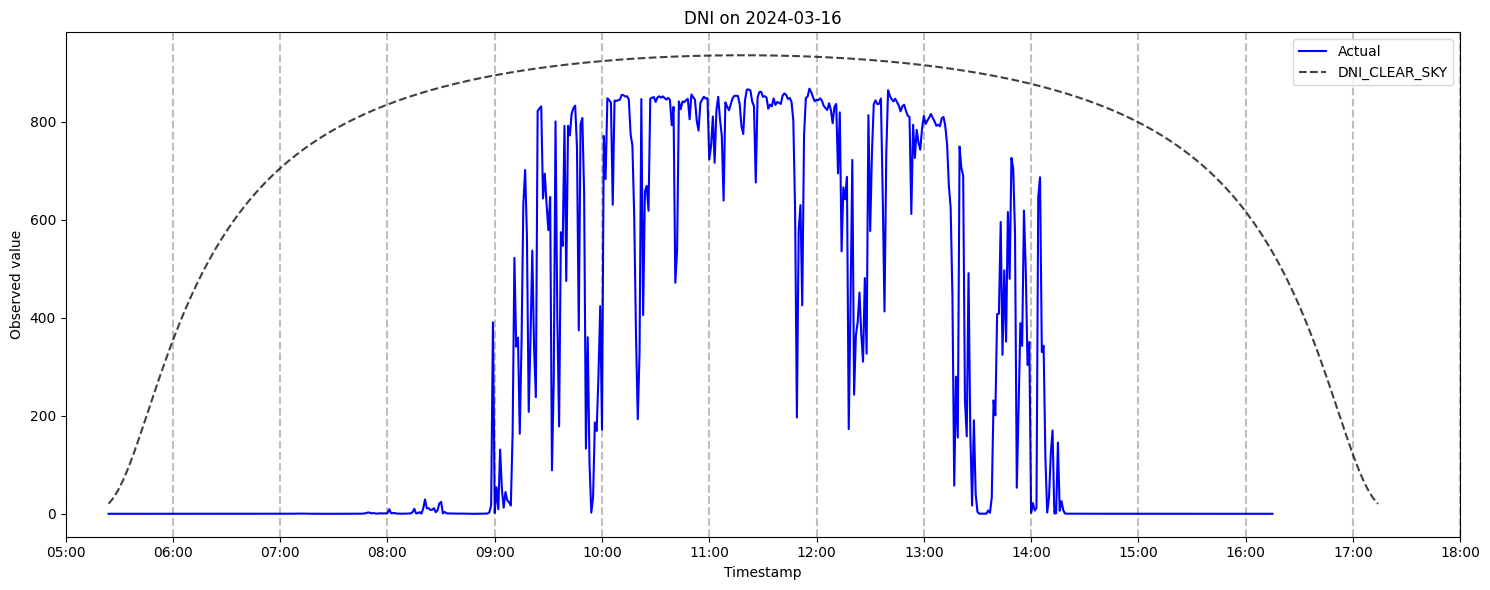

: 

In [ ]:
day = '2024-03-16'
day_start = pd.to_datetime(day)
day_end = day_start + pd.Timedelta(days=1)
# Filter the timestamps for the selected day
day_mask = (all_idx.index >= day_start) & (all_idx.index < day_end)
day_ts = all_idx[day_mask][0].values

import pandas as pd
import matplotlib.pyplot as plt

# 1) Build a list of every full hour from 00:00 to 23:00
day_date = pd.to_datetime(day).normalize()
hourly_ticks = [day_date + pd.Timedelta(hours=h) for h in range(24)]

fig, ax = plt.subplots(figsize=(15, 6))

# 2) Plot the true values
all_truths[day_mask][0].plot(
    ax=ax, label='Actual', color='blue'
)

data_loader.df.loc[day, [f'{TARGET}_CLEAR_SKY']].plot(
    ax=ax, label=f'{TARGET} Clear Sky', color='black', linestyle='--', alpha=0.75
)

# 3) Plot the predictions
# prediction_steps = list(range(0,6,1)) + list(range(10, 60, 10)) + [59]
# for i in prediction_steps:
#     all_preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}")

# 4) Add a dashed vertical line at each tick
for ht in hourly_ticks:
    ax.axvline(x=ht, color='black', linestyle='--', alpha=0.25)

# 5) Force exactly those 24 ticks, and label them “00:00”, “01:00”, …
ax.set_xticks(hourly_ticks)
ax.set_xticklabels([ht.strftime('%H:%M') for ht in hourly_ticks], rotation=0)

# 6) (Optional) Zoom the view to that exact day
# ax.set_xlim(hourly_ticks[0], hourly_ticks[-1])

ax.set_title(f"{my_config.get_df_target_names()[0]} on {day}")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Observed value")
ax.legend()
plt.tight_layout()
ax.set_xlim(pd.to_datetime(day + ' 05:00'), pd.to_datetime(day + ' 18:00'))

plt.savefig(f'./thesis_content/dni_single_day_2024-03-16.png', dpi=100)
plt.show()

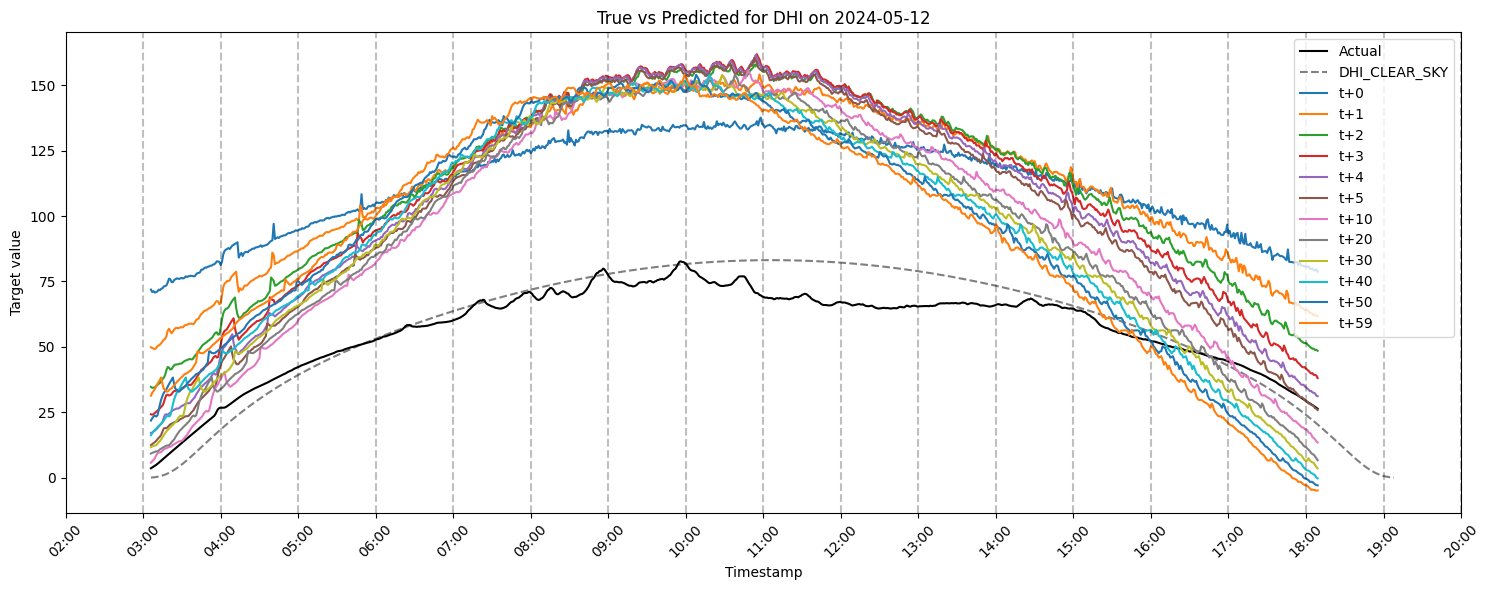

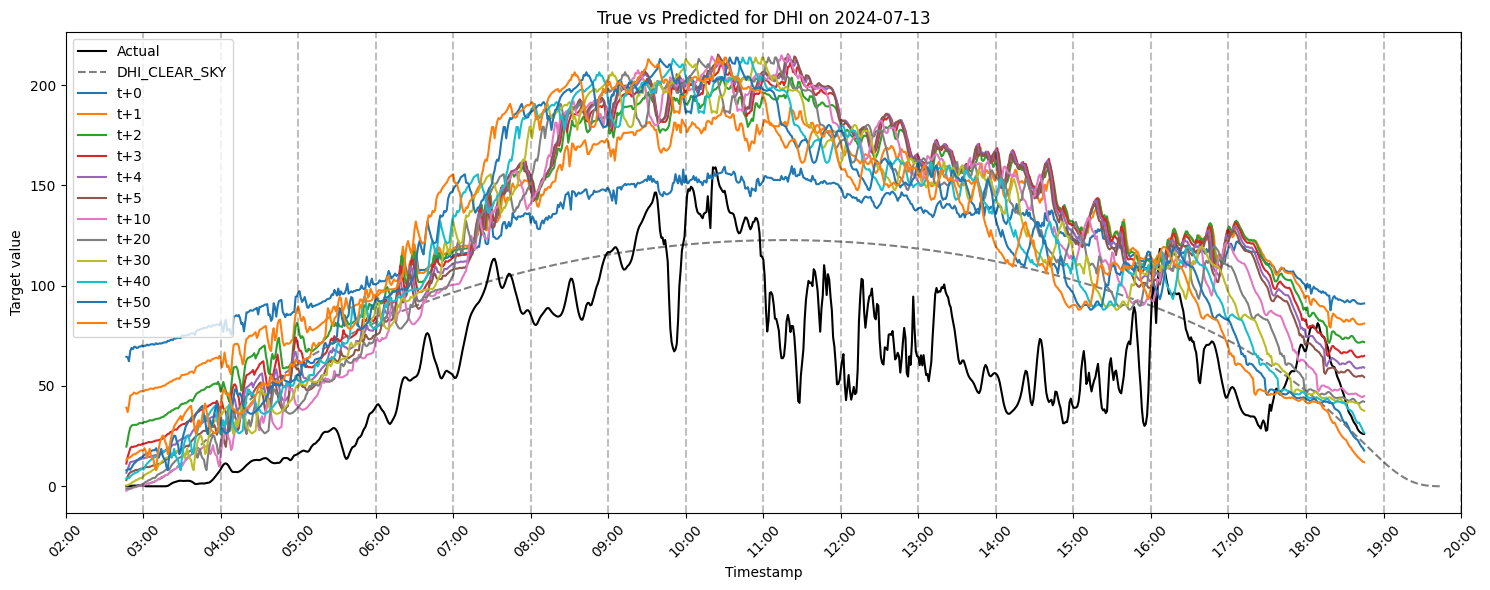

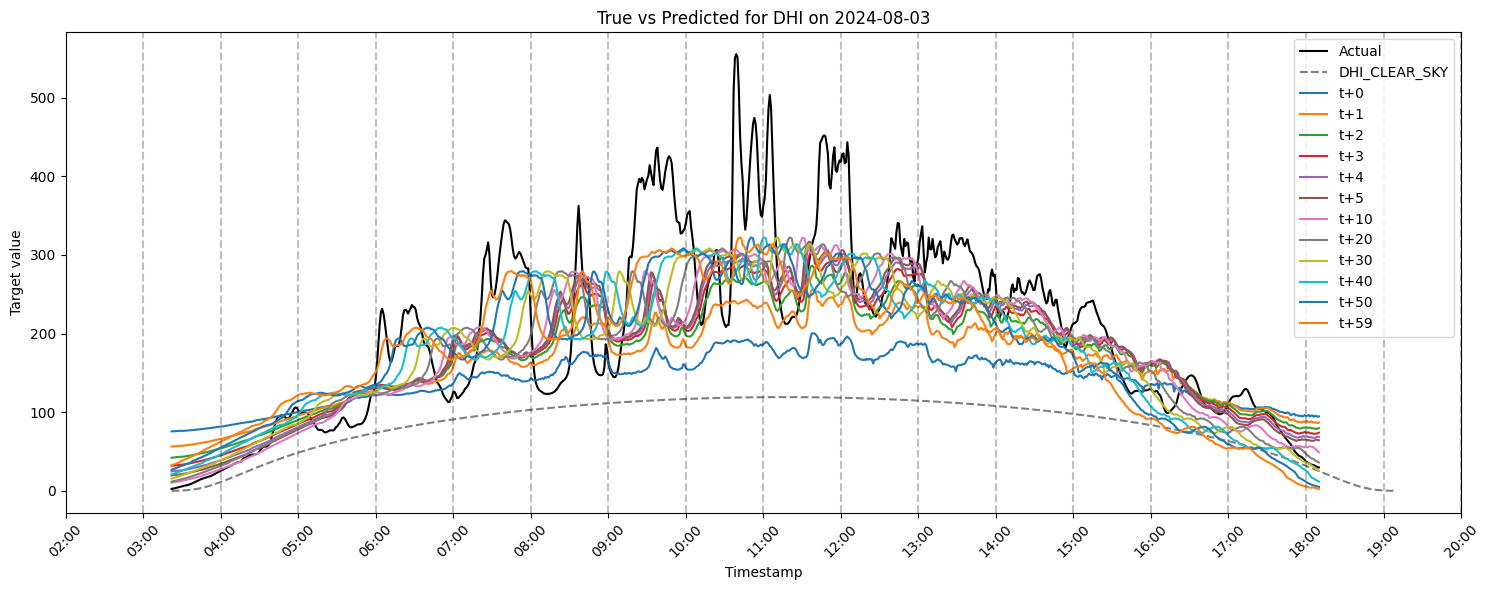

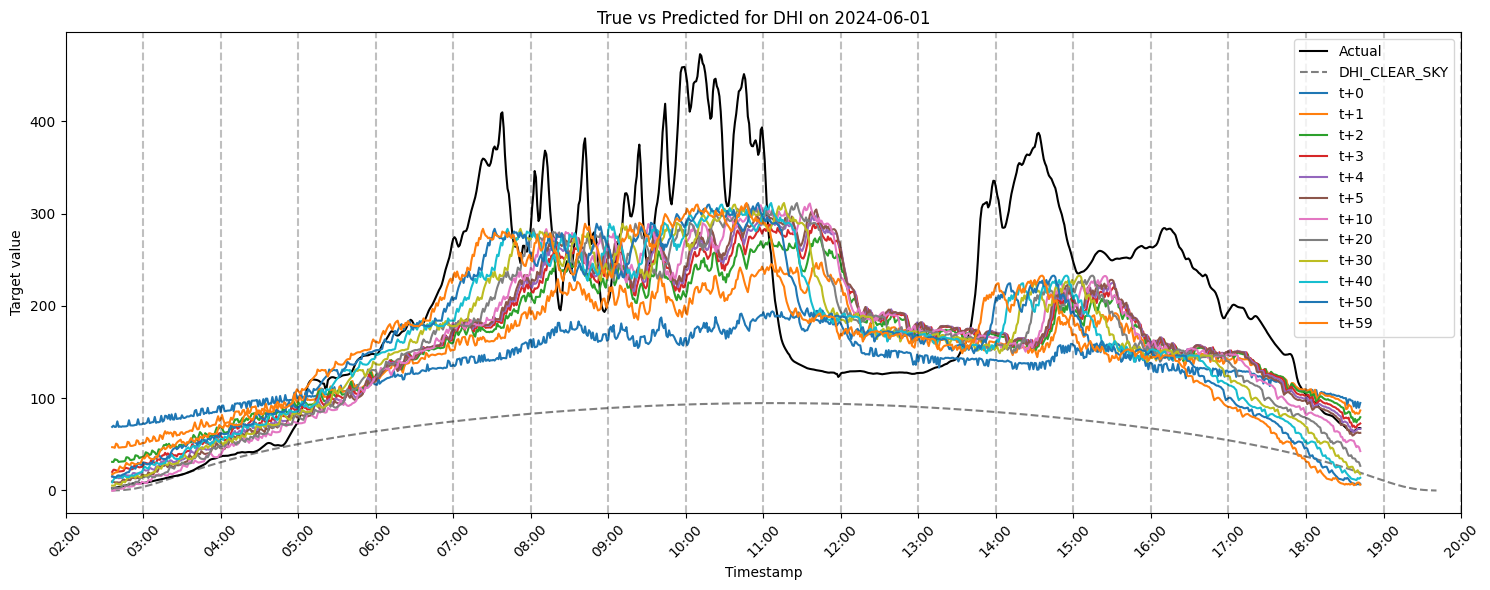

In [ ]:

sunny_date = '2024-05-12'
cloudy_date = '2024-07-13'
partially_cloudy_date = '2024-08-03'
cloudy_sunny_date = '2024-06-01'
for day in [sunny_date, cloudy_date, partially_cloudy_date, cloudy_sunny_date]:
    day_start = pd.to_datetime(day)
    day_end = day_start + pd.Timedelta(days=1)
    # Filter the timestamps for the selected day
    day_mask = (all_idx.index >= day_start) & (all_idx.index < day_end)
    day_ts = all_idx[day_mask][0].values

    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Build a list of every full hour from 00:00 to 23:00
    day_date = pd.to_datetime(day).normalize()
    hourly_ticks = [day_date + pd.Timedelta(hours=h) for h in range(24)]

    fig, ax = plt.subplots(figsize=(15, 6))

    # 2) Plot the true values
    all_truths[day_mask][0].plot(
        ax=ax, label='Actual', color='black'
    )

    data_loader.df.loc[day, [f'{TARGET}_CLEAR_SKY']].plot(
        ax=ax, label=f'{TARGET} Clear Sky', color='black', linestyle='--', alpha=0.5
    )

    # 3) Plot the predictions
    prediction_steps = list(range(0,6,1)) + list(range(10, 60, 10)) + [59]
    for i in prediction_steps:
        all_preds[day_mask][::1][i].plot(ax=ax, label=f"t+{i}")

    # 4) Add a dashed vertical line at each tick
    for ht in hourly_ticks:
        ax.axvline(x=ht, color='black', linestyle='--', alpha=0.25)

    # 5) Force exactly those 24 ticks, and label them “00:00”, “01:00”, …
    ax.set_xticks(hourly_ticks)
    ax.set_xticklabels([ht.strftime('%H:%M') for ht in hourly_ticks], rotation=45)

    # 6) (Optional) Zoom the view to that exact day
    # ax.set_xlim(hourly_ticks[0], hourly_ticks[-1])

    ax.set_title(f"True vs Predicted for {my_config.get_df_target_names()[0]} on {day}")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Target value")
    ax.legend()
    plt.tight_layout()
    ax.set_xlim(pd.to_datetime(day + ' 02:00'), pd.to_datetime(day + ' 20:00'))

    # plt.savefig(f'./thesis_content/{TARGET}_predictions_horizons_{day}.png', dpi=100)
    plt.show()
